In [1]:
import dowhy
import networkx as nx
import numpy as np

from pgmpy.models import BayesianNetwork
from pgmpy.factors.discrete import TabularCPD
from pgmpy.sampling import BayesianModelSampling
from pgmpy.inference import VariableElimination


/home/kuba/.cache/pypoetry/virtualenvs/examples-counterexamples-YUfXfKE6-py3.10/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Barber's burglary example

See chapter 3 of [Bayesian Reasoning and Machine Learning](http://web4.cs.ucl.ac.uk/staff/D.Barber/pmwiki/pmwiki.php?n=Brml.HomePage)

In [2]:
edges = [
    ("Earthquake", "Radio"),
    ("Earthquake", "Alarm"),
    ("Burglary", "Alarm"),
]
causal_graph = nx.DiGraph(edges)

INFO:dowhy.utils.plotting:Pygraphviz installation not found, falling back to networkx plotting. For better looking plots, consider installing pygraphviz. Note This requires both the Python pygraphviz package (``pip install pygraphviz``) and the shared system library (e.g. ``brew install graphviz`` or ``apt-get install graphviz``)


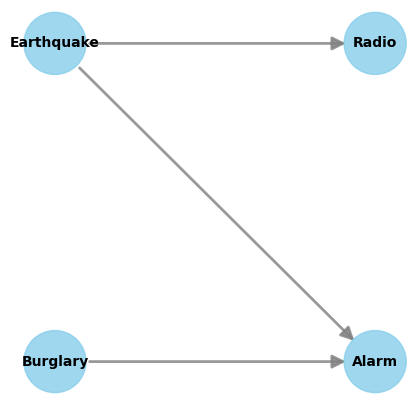

In [3]:
from dowhy.utils import plot

plot(causal_graph)

In [4]:
prob_alarm = np.array([0.0001, 0.99, 0.99, 0.99])


In [32]:
model = BayesianNetwork(edges)

p_earthquake = 0.01
cpd_earthquake = TabularCPD(variable='Earthquake', variable_card=2, values=[[1-p_earthquake], [p_earthquake]])
cpd_alarm = TabularCPD(variable='Alarm', variable_card=2, 
                   values=np.stack([1 - prob_alarm, prob_alarm]), 
                   evidence=['Earthquake', "Burglary"], evidence_card=[2,2])
cpd_burglary = TabularCPD(variable='Burglary', variable_card=2, 
                   values=[[0.99], [0.01]])
cpd_radi = TabularCPD(variable='Radio', variable_card=2, evidence=["Earthquake"], evidence_card=[2], values=[[1,0], [0, 1]])

In [33]:
model.add_cpds(cpd_earthquake, cpd_alarm, cpd_burglary, cpd_radi)

In [34]:
sampler = BayesianModelSampling(model)
samples = sampler.forward_sample(size=100)

print(samples)

Generating for node: Alarm: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 736.91it/s]

    Earthquake  Radio  Alarm  Burglary
0            0      0      0         0
1            0      0      0         0
2            0      0      0         0
3            0      0      0         0
4            0      0      0         0
..         ...    ...    ...       ...
95           0      0      0         0
96           0      0      0         0
97           0      0      0         0
98           0      0      0         0
99           0      0      0         0

[100 rows x 4 columns]



/home/kuba/.cache/pypoetry/virtualenvs/examples-counterexamples-YUfXfKE6-py3.10/lib/python3.10/site-packages/pgmpy/sampling/base.py:582: FutureWarning: Passing a DataFrame to DataFrame.from_records is deprecated. Use set_index and/or drop to modify the DataFrame instead.
  df = pd.DataFrame.from_records(samples)


The earthquake probability was modified from original example to show the dramatic effect of another possible cause

What can we tell if we do not know if radio informed about earthquake?

P(Burglary=1|Alarm=1)

In [38]:
infer = VariableElimination(model)
infer.query(variables=['Burglary'], evidence={'Alarm': 1}).values[1]

If we hear the radio it means that alarm was unlikely 

P(Burglary=1|Alarm=1, Radio=1)

In [39]:
infer.query(variables=['Burglary'], evidence={'Alarm': 1, "Radio": 1}).values[1]

P(Burglary=1|Alarm=1,Radio=0)

In [40]:
infer.query(variables=['Burglary'], evidence={'Alarm': 1, "Radio": 0}).values[1]